In [1]:
import tensorflow
import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout,SpatialDropout1D,Bidirectional,LSTM,SimpleRNN
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D,GlobalMaxPooling1D

import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer



In [2]:


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
mapping = dict(positive=1,
               negative=0)

# creating a mapping to encode the labels
df['sentiment'] = df['sentiment'].map(mapping)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:


# Finding the value counts for each label
df.sentiment.value_counts()



1    25000
0    25000
Name: sentiment, dtype: int64

In [6]:
# checking out if there is any null values in the dataset
df.isna().sum()

# no null values seems to be found

review       0
sentiment    0
dtype: int64

In [7]:
# converting the sentiment column of the dataframe to numpy array
label = df['sentiment']
label = label.to_numpy()
type(label)

numpy.ndarray

In [8]:
# downloading nltk dependencies
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
all_stopwords = stopwords.words('english')
negation = ['no','not']
all_stopwords = [w for w in all_stopwords if w not in negation]

def preprocessing(data):
    corpus = []
    for i in range(len(data)):
        # remove urls
        tweet = re.sub(r'http\S+', ' ', data[i]) # links

        # remove html tags
        tweet = re.sub(r'<.*?>', ' ', tweet) # tags        
        tweet = re.sub('&\w+([-.]\w+)*', ' ', tweet) # colorcodes

        # remove digits
        tweet = re.sub(r'\d+', ' ', tweet)
        tweet = re.sub('@\w+([-.]\w+)*', ' ', tweet) # mentions

        # remove emojis
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
        tweet = emoji_pattern.sub(r'', tweet) # no emoji

        # remove hashtags
        tweet = re.sub(r'#\w+', ' ', tweet) # hashtags
        review = re.sub('[^a-zA-Z]', ' ', tweet) # any characters other than alphabets
        review = review.lower() # casefolding
        review = review.split() 
        lemma= WordNetLemmatizer() # lemmatization
        review = [lemma.lemmatize(word) for word in review if word not in all_stopwords]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

In [10]:
review = preprocessing(df['review'])

In [11]:
X_train, X_test,y_train,y_test = train_test_split(review,label,test_size=0.20,stratify = label,random_state=42)

In [12]:
token = Tokenizer()
token.fit_on_texts(X_train)

In [13]:
# Convert text data to sequences of integers
train_sequences = token.texts_to_sequences(X_train)
valid_sequences = token.texts_to_sequences(X_test)

In [14]:
vocab_size = len(token.word_index)+1
vocab_size

# there are 89657 unique words in the corpus 
# we will feed this to the input_dim of embedding layer
# +1 because the index starts from 0

81371

In [15]:
maxlen = 100 # specifies the maximum length of the sequences after padding or truncating.

X_train = pad_sequences(train_sequences, maxlen=maxlen,padding = 'post')
X_test = pad_sequences(valid_sequences, maxlen=maxlen,padding = 'post')

In [16]:
X_train.shape

(40000, 100)

In [17]:
from keras.layers import LSTM

In [18]:
vec_size = 300
lstm =Sequential()
# Embedding layer
lstm.add(Embedding(input_dim = vocab_size, output_dim = vec_size,input_length=maxlen,trainable = False))
#lstm
lstm.add(LSTM(200,dropout=0.20))
lstm.add(Dense(1,activation='sigmoid'))

In [19]:
lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
lstm_history = lstm.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test))

Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6850 - accuracy: 0.5411 - val_loss: 0.6863 - val_accuracy: 0.5640
Epoch 2/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6753 - accuracy: 0.5732 - val_loss: 0.6808 - val_accuracy: 0.5661
Epoch 3/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6659 - accuracy: 0.5853 - val_loss: 0.6429 - val_accuracy: 0.6296
Epoch 4/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.5917 - accuracy: 0.6783 - val_loss: 0.5118 - val_accuracy: 0.7418
Epoch 5/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.5197 - accuracy: 0.7380 - val_loss: 0.5076 - val_accuracy: 0.7427
Epoch 6/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4849 - accuracy: 0.7631 - val_loss: 0.4634 - val_accuracy: 0.7753
Epoch 7/15
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4646 - accuracy: 0.7737 - val_loss: 0.4512 - val_accuracy:

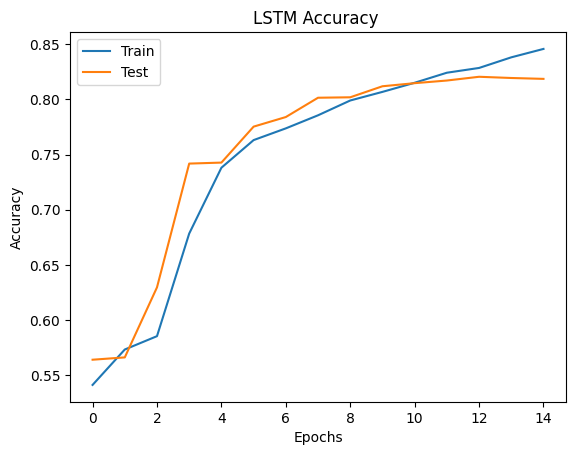

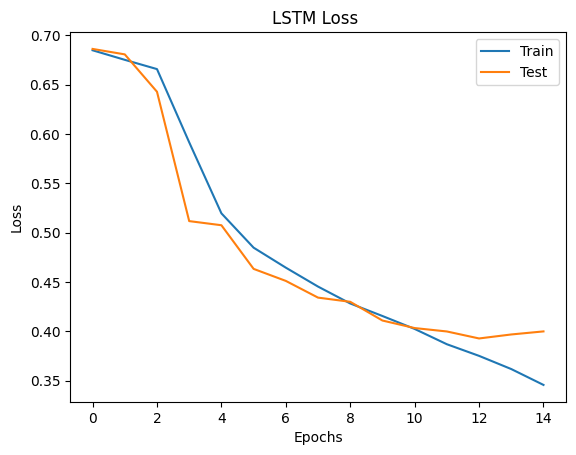

In [26]:
import matplotlib.pyplot as plt
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title("LSTM Accuracy ")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()


plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title("LSTM Loss ")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()

In [27]:
import pickle
with open ("lstm_sentiment_analysis.pkl",'wb') as f:
    pickle.dump(lstm,f)

In [28]:
score_lstm = lstm.evaluate(X_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.4000 - accuracy: 0.8186


In [29]:
print("Test loss :",score_lstm[0])
print("Test Accuracy :",score_lstm[1])

Test loss : 0.40001529455184937
Test Accuracy : 0.8185999989509583
